# Определение возраста покупателей

Описание данных:  

Данные взяты с сайта [ChaLearn Looking at People ](https://chalearnlap.cvc.uab.cat/dataset/26/description/) и собраны в папку с изображениями + файл с метками возраста для них.  
Метрика качества модели: `mae`  
Задача:  
Добиться значения метрики качества `<= 8`

## Исследовательский анализ данных

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


Не все названия фото соответствуют и порядковому номеру.

In [4]:
labels.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 556.1 KB


Типы данных верны, пропусков нет, расход памяти небольшой.

In [5]:
labels.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201,17.145,1.0,20.0,29.0,41.0,100.0


Средний возраст = 31.2 года.  
Медианный возраст = 29 лет.  
Размах от 1 до 100.  

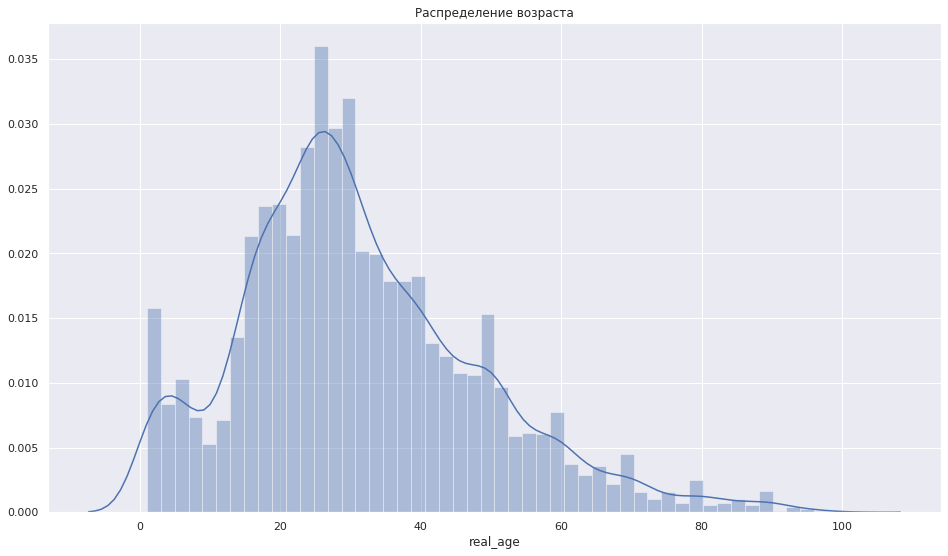

In [6]:

plt.figure(figsize=(16,9))
sns.set()
sns.distplot(labels['real_age'], bins=50);
plt.title('Распределение возраста');


Выделяется количество возрастов до 8 лет и с 24 до 30 лет.  
Имеется бимодальность, скорее всего из-за того что выборка состоит из нескольких подвыборок.  
Немного фото людей старше 60 лет.    

In [7]:

train_datagen = ImageDataGenerator(rescale=1./255)
 
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


Found 7591 validated image filenames.


Все фото определились.  

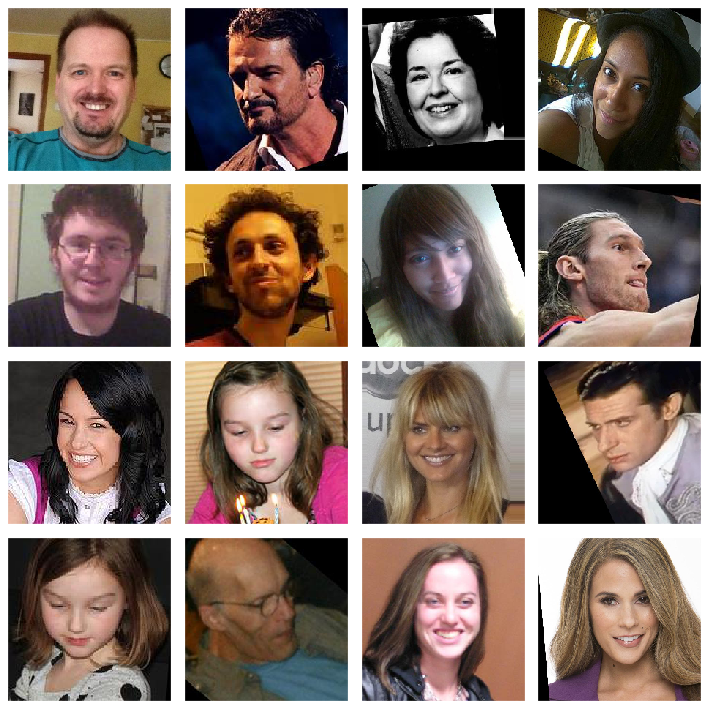

In [8]:

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(train_gen_flow[i][0][0])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    

Фото есть большие и маленькие.  
Четкие и размытые.   
Прямые и повернутые.  
Цветные и черно-белые.   
Набор имеет разнообразие которое может облегчить обучение.  

### Вывод:

Средний возраст = 31.2 года.  
Медианный возраст = 29 лет.  
Размах от 1 до 100.  
Из-за небольшого количества фото возрастов более 60 и от 8 до 12 лет, модель может в них чаще ошибаться.  
Фото уже имеют некоторые свойства подготовленных к обучению модели.  

## Обучение модели

Здесь отдлеьно описан код который запускался на отдельной машине с `GPU`

```python

import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_gen_flow, test_gen_flow, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_gen_flow,
              validation_data=test_gen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle = True)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps

Epoch 1/5
356/356 - 46s - loss: 235.6209 - mae: 11.3299 - val_loss: 599.0799 - val_mae: 19.2850
Epoch 2/5
356/356 - 38s - loss: 112.9364 - mae: 8.0779 - val_loss: 210.2287 - val_mae: 10.6867
Epoch 3/5
356/356 - 38s - loss: 89.3001 - mae: 7.1897 - val_loss: 106.5978 - val_mae: 7.8392
Epoch 4/5
356/356 - 38s - loss: 72.1568 - mae: 6.4782 - val_loss: 83.4788 - val_mae: 6.8886
Epoch 5/5
356/356 - 38s - loss: 58.0264 - mae: 5.8235 - val_loss: 84.0119 - val_mae: 6.7908

119/119 - 9s - loss: 84.0119 - mae: 6.7908
Test MAE: 6.7908

```

## Анализ обученной модели

Значение функции потерь `mse`, говорит о том, что есть ошибки поднимающие ее значение на тестовой выборке.  
Однако, взяв за основу архитектуру `ResNet`, и почти не меняя изображения, нам удалось достичь нужного значения метрики.  
Разнообразие фотографий дало модели достаточный набор признаков для данной задачи.   